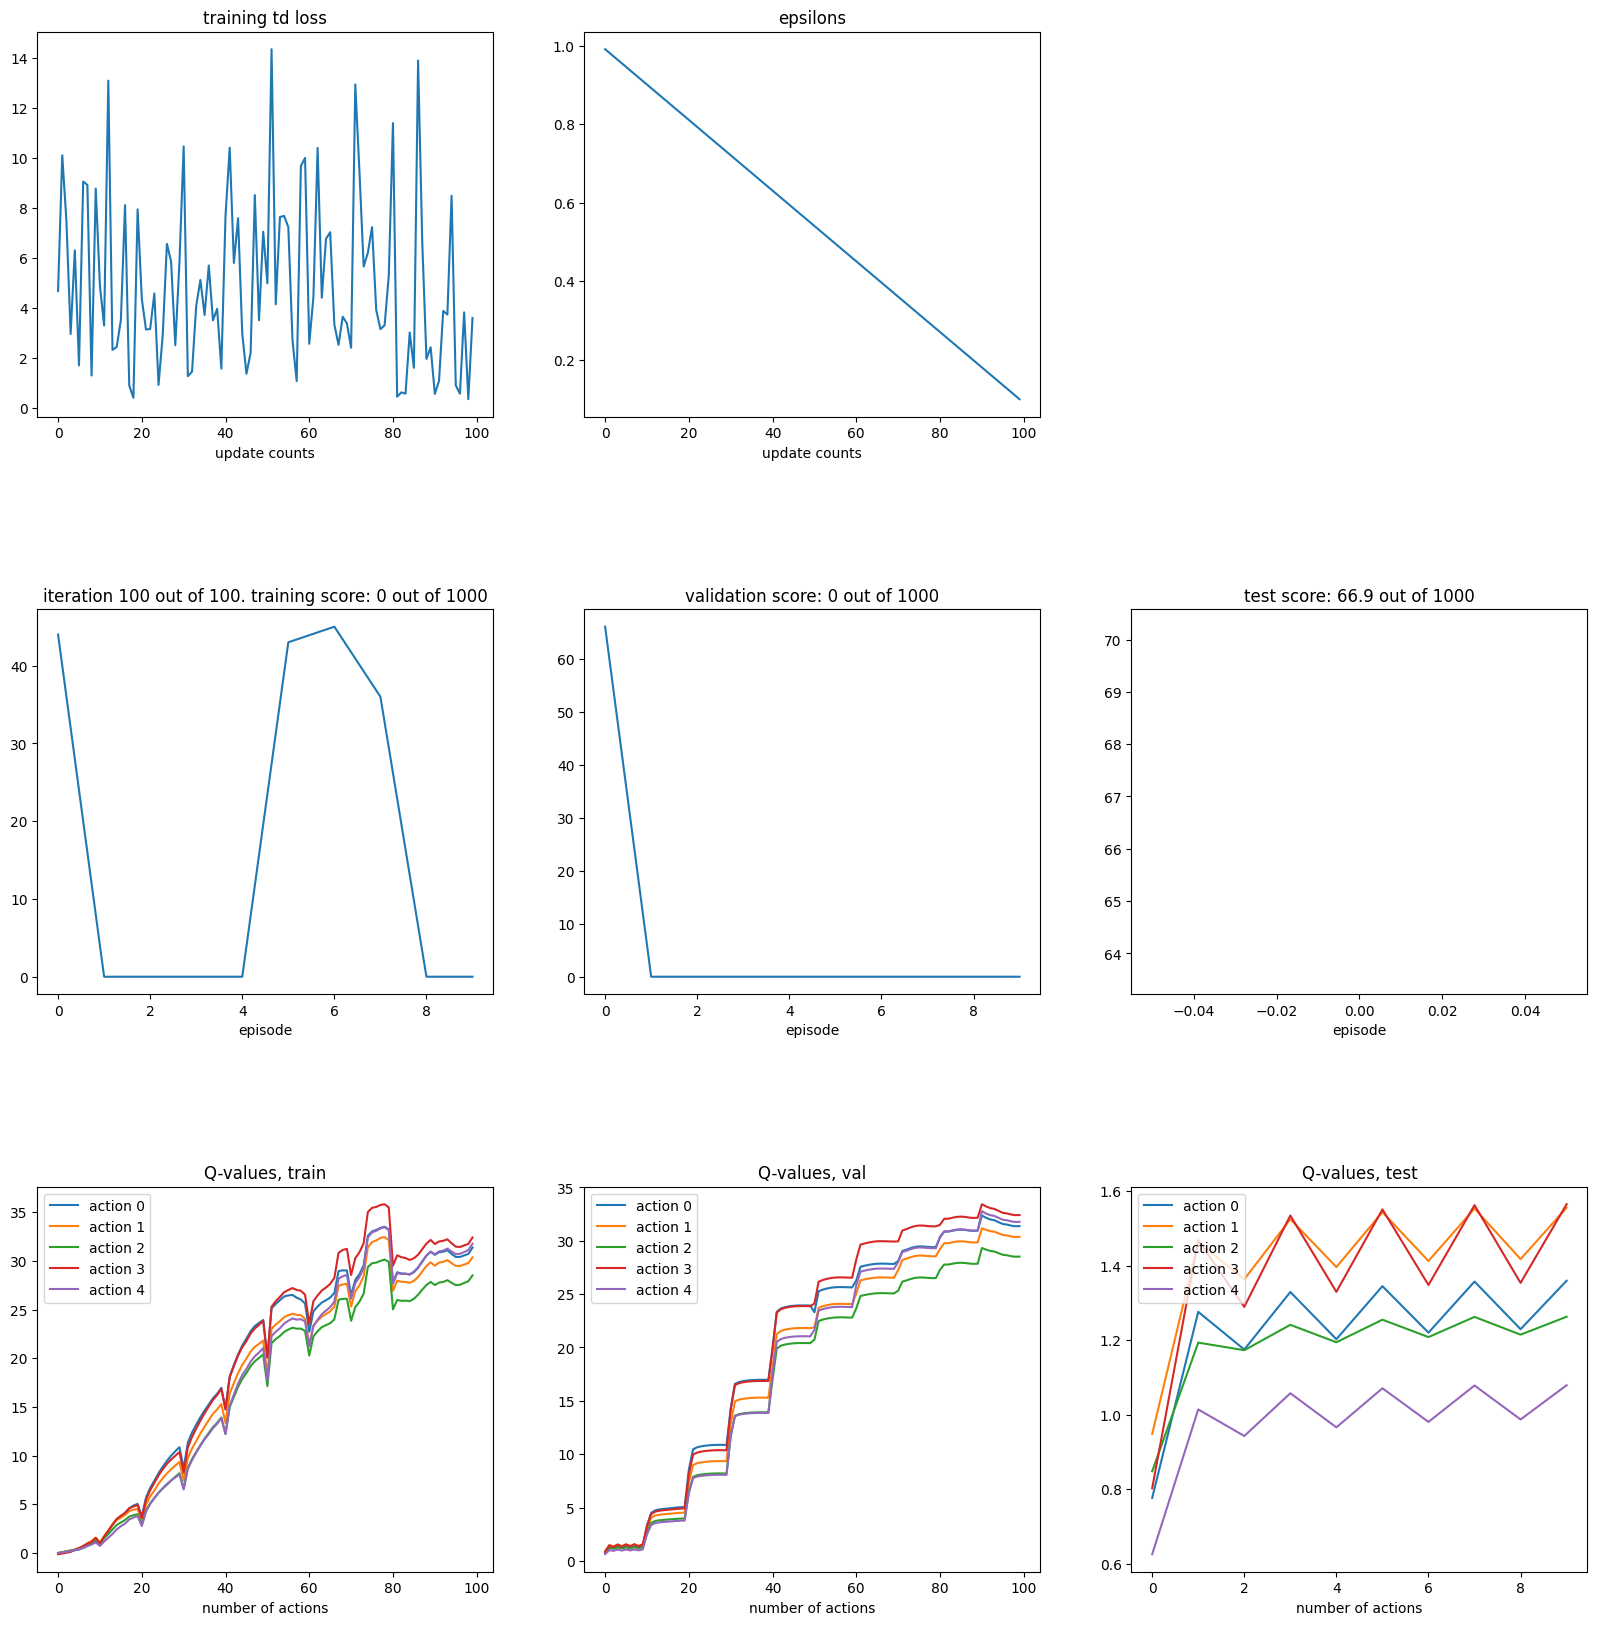

In [2]:
from agent.dqn import DQNLSTMBaselineAgent
from tqdm.auto import tqdm
from copy import deepcopy
import random
import logging

logger = logging.getLogger()
logger.disabled = True


history_block_size = 6

params = {
    "env_str": "room_env:RoomEnv-v2",
    "num_iterations": 100 * 100,
    "replay_buffer_size": 100 * 100,
    "warm_start": 100 * 100 / 10,
    "batch_size": 32,
    "target_update_interval": 10,
    "epsilon_decay_until": 100 * 100,
    "max_epsilon": 1.0,
    "min_epsilon": 0.1,
    "gamma": 0.9,
    "history_block_size": history_block_size,
    "nn_params": {
        "architecture": "lstm",
        "hidden_size": 128,
        "num_layers": 2,
        "embedding_dim": 128,
        "fuse_information": "sum",
        "include_positional_encoding": True,
        "max_timesteps": 100,
        "max_strength": 100,
    },
    "run_test": True,
    "num_samples_for_results": 10,
    "plotting_interval": 10,
    "train_seed": 5,
    "test_seed": 0,
    "device": "cpu",
    "env_config": {
        "question_prob": 1.0,
        "terminates_at": 99,
        "randomize_observations": "objects",
        "room_size": "l",
        "rewards": {"correct": 1, "wrong": 0, "partial": 0},
        "make_everything_static": False,
        "num_total_questions": 1000,
        "question_interval": 1,
        "include_walls_in_observations": True,
    },
    "ddqn": True,
    "dueling_dqn": True,
    "default_root_dir": f"./training_results/baselines/dqn_lstm/history_block_size={history_block_size}/TRASH",
    "run_handcrafted_baselines": True,
}


agent = DQNLSTMBaselineAgent(**params)
agent.train()

In [10]:
total_params = sum(p.numel() for p in agent.dqn.parameters())
total_params

302598

In [11]:
210564 + 144134

354698

In [ ]:
agent.dqn.forward(agent.replay_buffer.sample_batch()["obs"])

In [ ]:
max_len = 0
for e in agent.replay_buffer.sample_batch()["obs"]:
    max_len = max(max_len, len(e["data"]))

In [ ]:
max_len

In [ ]:
from agent.dqn import DQNMMAgent, DQNExploreAgent
from tqdm.auto import tqdm
from copy import deepcopy
import random
import logging

logger = logging.getLogger()
logger.disabled = True


config = {
    "question_prob": 1.0,
    "terminates_at": 99,
    "randomize_observations": "objects",
    "room_size": "l",
    "rewards": {"correct": 1, "wrong": 0, "partial": 0},
    "make_everything_static": False,
    "num_total_questions": 1000,
    "question_interval": 1,
    "include_walls_in_observations": True,
}

params = {
    "env_str": "room_env:RoomEnv-v2",
    "max_epsilon": 1.0,
    "min_epsilon": 0.1,
    "epsilon_decay_until": 100 * 100,
    "gamma": 0.9,
    "capacity": {
        "episodic": 16,
        "episodic_agent": 0,
        "semantic": 16,
        "semantic_map": 0,
        "short": 1,
    },
    "nn_params": {
        "architecture": "lstm",
        "hidden_size": 64,
        "num_layers": 2,
        "embedding_dim": 64,
        "make_categorical_embeddings": False,
        "v1_params": None,
        "v2_params": {},
        "memory_of_interest": [
            "episodic",
            "semantic",
            "short",
        ],
        "fuse_information": "sum",
        "include_positional_encoding": True,
        "max_timesteps": config["terminates_at"] + 1,
        "max_strength": config["terminates_at"] + 1,
    },
    "num_iterations": 100 * 100,
    "replay_buffer_size": 100 * 100,
    "warm_start": 100 * 100 / 10,
    "batch_size": 32,
    "target_update_interval": 10,
    "pretrain_semantic": False,
    "run_test": True,
    # "num_samples_for_results": 10,
    "num_samples_for_results": 1,
    "train_seed": 5,
    "plotting_interval": 10,
    "device": "cpu",
    "test_seed": 0,
    # "mm_policy": "neural",
    # "mm_agent_path": "trained-agents/lstm-mm/2023-12-28 18:13:03.001952/agent.pkl",
    "env_config": config,
    "qa_policy": "episodic_semantic",
    "explore_policy": "avoid_walls",
    "ddqn": True,
    "dueling_dqn": True,
    "default_root_dir": "training_results/mm/TRASH",
    "run_handcrafted_baselines": [
        {
            "mm": mm,
            "qa": qa,
            "explore": explore,
            "pretrain_semantic": pretrain_semantic,
        }
        for mm in ["random", "episodic", "semantic"]
        for qa in ["episodic_semantic"]
        for explore in ["random", "avoid_walls"]
        for pretrain_semantic in [False, "exclude_walls"]
    ],
}


agent = DQNMMAgent(**params)
agent.train()

In [ ]:
agent.dqn

In [ ]:
total_params = sum(p.numel() for p in agent.dqn.parameters())
total_params

In [13]:
import numpy as np
import random


class History:
    def __init__(self, block_size: int = 6) -> None:
        self.block_size = block_size
        self.blocks = [[]] * self.block_size

    def to_list(self) -> list:
        return [element for block in self.blocks for element in block]

    def add_block(self, block: list) -> None:
        self.blocks = self.blocks[1:] + [block]

    def add_action(self, action: int) -> None:
        assert action in [0, 1, 2, 3, 4]
        self.blocks[-1].append(action)

    def add_reward(self, reward: int) -> None:
        self.blocks[-1].append(reward)

    def __repr__(self) -> str:
        return str(self.blocks)

    def answer_question(self, question: list) -> str:
        """Answer a question, by going through the history in backwards."""
        assert len(question) == 4 and question[2] == "?"
        for obs in self.to_list()[::-1]:
            if obs[0] == question[0] and obs[1] == question[1]:
                return obs[2]

    def answer_questions(self, questions: list[list[str]]) -> list[str]:
        """Answer a list of questions."""
        return [self.answer_question(question) for question in questions]

    def find_agent_current_location(self) -> str | None:
        """Find the current location of the agent, by going through the history in
        backwards."""
        for obs in self.to_list()[::-1]:
            if obs[0] == "agent" and obs[1] == "atlocation":
                return obs[2]

        return None

    def explore(self, explore_policy: str) -> str:
        if explore_policy not in ["random", "avoid_walls"]:
            raise ValueError(f"Unknown explore policy: {explore_policy}")

        if explore_policy == "random":
            action_explore = random.choice(["north", "east", "south", "west", "stay"])
        elif explore_policy == "avoid_walls":
            current_agent_location = self.find_agent_current_location()
            if current_agent_location is None:
                action_explore = random.choice(
                    ["north", "east", "south", "west", "stay"]
                )
            else:
                relevant_observations = []
                relevant_observations += [
                    obs
                    for obs in self.to_list()[::-1]
                    if obs[0] == current_agent_location
                    and obs[1] in ["north", "east", "south", "west"]
                ]
                # we know the agent's current location but there is no memory about map
                if len(relevant_observations) == 0:
                    action_explore = random.choice(
                        ["north", "east", "south", "west", "stay"]
                    )
                else:
                    # we know the agent's current location and there is at least one
                    # memory about the map and we want to avoid the walls

                    to_take = []
                    to_avoid = []

                    for obs in relevant_observations:
                        if obs[2].split("_")[0] == "room":
                            to_take.append(obs[1])
                        elif obs[2] == "wall":
                            if obs[1] not in to_avoid:
                                to_avoid.append(obs[1])

                    if len(to_take) > 0:
                        action_explore = random.choice(to_take)
                    else:
                        options = ["north", "east", "south", "west", "stay"]
                        for e in to_avoid:
                            options.remove(e)

                        action_explore = random.choice(options)

        return action_explore

In [14]:
import gymnasium as gym

for explore_policy in ["random", "avoid_walls"]:
    for history_block_size in [6, 12, 24, 48]:
        scores = []
        for test_seed in [0, 1, 2, 3, 4]:
            score = 0
            env = gym.make("room_env:RoomEnv-v2", seed=test_seed)
            observations, info = env.reset()
            history = History(history_block_size)

            while True:
                history.add_block(observations["room"])

                actions_qa = history.answer_questions(observations["questions"])
                action_explore = history.explore(explore_policy)

                action_pair = (actions_qa, action_explore)
                (
                    observations,
                    reward,
                    done,
                    truncated,
                    info,
                ) = env.step(action_pair)
                score += reward

                if done:
                    break

        scores.append(score)
        print(history_block_size, explore_policy, np.mean(scores), np.std(scores))
        print()

6 random 156.0 0.0

12 random 224.0 0.0

24 random 284.0 0.0

48 random 335.0 0.0

6 avoid_walls 260.0 0.0

12 avoid_walls 230.0 0.0

24 avoid_walls 419.0 0.0

48 avoid_walls 491.0 0.0



In [15]:
history.to_list()

[['room_004', 'north', 'room_001', 52],
 ['room_004', 'east', 'wall', 52],
 ['room_004', 'south', 'room_008', 52],
 ['room_004', 'west', 'wall', 52],
 ['agent', 'atlocation', 'room_004', 52],
 ['sta_003', 'atlocation', 'room_004', 52],
 ['room_008', 'north', 'room_004', 53],
 ['room_008', 'east', 'room_009', 53],
 ['room_008', 'south', 'room_011', 53],
 ['room_008', 'west', 'room_007', 53],
 ['agent', 'atlocation', 'room_008', 53],
 ['room_011', 'north', 'room_008', 54],
 ['room_011', 'east', 'wall', 54],
 ['room_011', 'south', 'room_012', 54],
 ['room_011', 'west', 'wall', 54],
 ['agent', 'atlocation', 'room_011', 54],
 ['ind_001', 'atlocation', 'room_011', 54],
 ['ind_003', 'atlocation', 'room_011', 54],
 ['room_012', 'north', 'room_011', 55],
 ['room_012', 'east', 'wall', 55],
 ['room_012', 'south', 'room_014', 55],
 ['room_012', 'west', 'wall', 55],
 ['agent', 'atlocation', 'room_012', 55],
 ['sta_000', 'atlocation', 'room_012', 55],
 ['room_011', 'north', 'room_008', 56],
 ['room_

In [16]:
observations_room_len = []
for test_seed in [0, 1, 2, 3, 4]:
    len_ = []
    env = gym.make("room_env:RoomEnv-v2", seed=test_seed)
    observations, info = env.reset()

    while True:
        action_pair = (
            ["foo"] * 10,
            random.choice(["north", "east", "south", "west", "stay"]),
        )
        (
            observations,
            reward,
            done,
            truncated,
            info,
        ) = env.step(action_pair)

        len_.append(len(observations["room"]))

        if done:
            break
    observations_room_len.append(np.mean(len_).item())

In [18]:
np.mean(observations_room_len)

5.715999999999999

In [9]:
32 / np.mean(observations_room_len)

5.598320503848846

In [ ]:
len(observations["room"])

In [ ]:
scores_to_compare

In [ ]:
import gymnasium as gym

env = gym.make("room_env:RoomEnv-v2")
observations, info = env.reset()
history.add_block(observations["room"])

rewards = []
while True:
    (
        observations,
        reward,
        done,
        truncated,
        info,
    ) = env.step(
        (
            history.answer_questions(observations["questions"]),
            random.choice(["north", "east", "west", "south", "stay"]),
        )
    )
    rewards.append(reward)

    if done or truncated:
        break
    history.add_block(observations["room"])
print(sum(rewards))

In [ ]:
history.to_list()

In [ ]:
observations["questions"]

In [ ]:
history.blocks

In [ ]:
history

In [ ]:
(
    observations,
    reward,
    done,
    truncated,
    info,
) = env.step((["foo"] * 10, "east"))

In [ ]:
history.add_block(observations["room"])

In [ ]:
history.list()

In [ ]:
foo.add_action(0)
foo

In [ ]:
foo.add_reward(10)
foo

In [ ]:
from humemai.utils import ReplayBuffer

replay_buffer = ReplayBuffer(observation_type="dict", size=4, batch_size=2)

replay_buffer.store(*[foo.list(), 0, 10, foo.list(), False])
replay_buffer.store(*[foo.list(), 0, 10, foo.list(), False])
replay_buffer.store(*[foo.list(), 0, 10, foo.list(), False])
replay_buffer.store(*[foo.list(), 0, 10, foo.list(), False])

In [ ]:
replay_buffer.sample_batch()

In [ ]:
from agent.dqn import DQNMMAgent, DQNExploreAgent
from tqdm.auto import tqdm
from copy import deepcopy
import random
import logging

logger = logging.getLogger()
logger.disabled = True


config = {
    "question_prob": 1.0,
    "terminates_at": 99,
    "randomize_observations": "objects",
    "room_size": "l",
    "rewards": {"correct": 1, "wrong": 0, "partial": 0},
    "make_everything_static": False,
    "num_total_questions": 1000,
    "question_interval": 1,
    "include_walls_in_observations": True,
}

params = {
    "env_str": "room_env:RoomEnv-v2",
    "max_epsilon": 1.0,
    "min_epsilon": 0.1,
    "epsilon_decay_until": 100 * 100,
    "gamma": 0.9,
    "capacity": {
        "episodic": 16,
        "episodic_agent": 0,
        "semantic": 16,
        "semantic_map": 0,
        "short": 1,
    },
    "nn_params": {
        "architecture": "lstm",
        "hidden_size": 64,
        "num_layers": 2,
        "embedding_dim": 64,
        "make_categorical_embeddings": False,
        "v1_params": None,
        "v2_params": {},
        "memory_of_interest": [
            "episodic",
            "semantic",
        ],
        "fuse_information": "sum",
        "include_positional_encoding": True,
        "max_timesteps": config["terminates_at"] + 1,
        "max_strength": config["terminates_at"] + 1,
    },
    "num_iterations": 100 * 100,
    "replay_buffer_size": 100 * 100,
    "warm_start": 100 * 100 / 10,
    "batch_size": 32,
    "target_update_interval": 10,
    "pretrain_semantic": False,
    "run_test": True,
    "num_samples_for_results": 10,
    "train_seed": 5,
    "plotting_interval": 10,
    "device": "cpu",
    "test_seed": 0,
    "mm_policy": "neural",
    "mm_agent_path": "trained-agents/lstm-mm/2023-12-28 18:13:03.001952/agent.pkl",
    "env_config": config,
    "qa_policy": "episodic_semantic",
    "ddqn": True,
    "dueling_dqn": True,
    "default_root_dir": "training_results/explore/TRASH",
    "run_handcrafted_baselines": [
        {
            "mm": mm,
            "qa": qa,
            "explore": explore,
            "pretrain_semantic": pretrain_semantic,
        }
        for mm in ["random", "episodic", "semantic"]
        for qa in ["episodic_semantic"]
        for explore in ["random", "avoid_walls"]
        for pretrain_semantic in [False, "exclude_walls"]
    ],
}


agent = DQNExploreAgent(**params)
agent.train()